# Introduction

**머신러닝을 몰라도 "Config"에 5가지만 넣으면, 실행할 수 있게 만들었습니다.<br>
Even if you don't know machine learning, you can submit only 5 things in "config"**

회사에서 많이 사용하게 만들었었고, 도움이 많이 될 겁니다.<br> 
I made a lot of use of it in company, and it will help a lot.

타이타닉 데이터 기준으로 모델링을 진행하였고, 이후 분류 문제에 대하여 테스트 진행해 보았습니다.<br>
어떤한 분류 문제에 대하여도 해결할 수 있는 자동적인 모델을 만드는 목표로 작업하고 있습니다.<br> 
비기능적인 요소인 속도 부분도 감안하였고, 최대한 간결하게 작성하도록 노력 했습니다.<br>
<br>
Modeling was performed based on the Titanic data, and then the classification problem was tested.<br>
We are working with the goal of creating an automatic model that can solve any classification problem.<br>
The speed part, which is a non-functional factor, was also taken into consideration, and I tried to write it as concisely as possible.

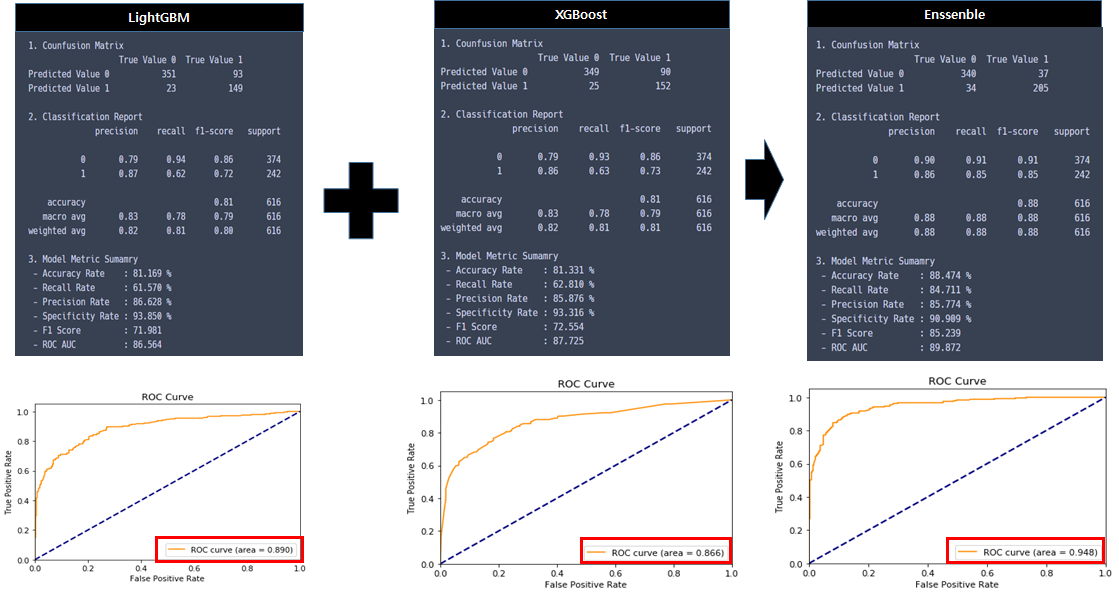

# Home Credit Default Risk Data Analysis

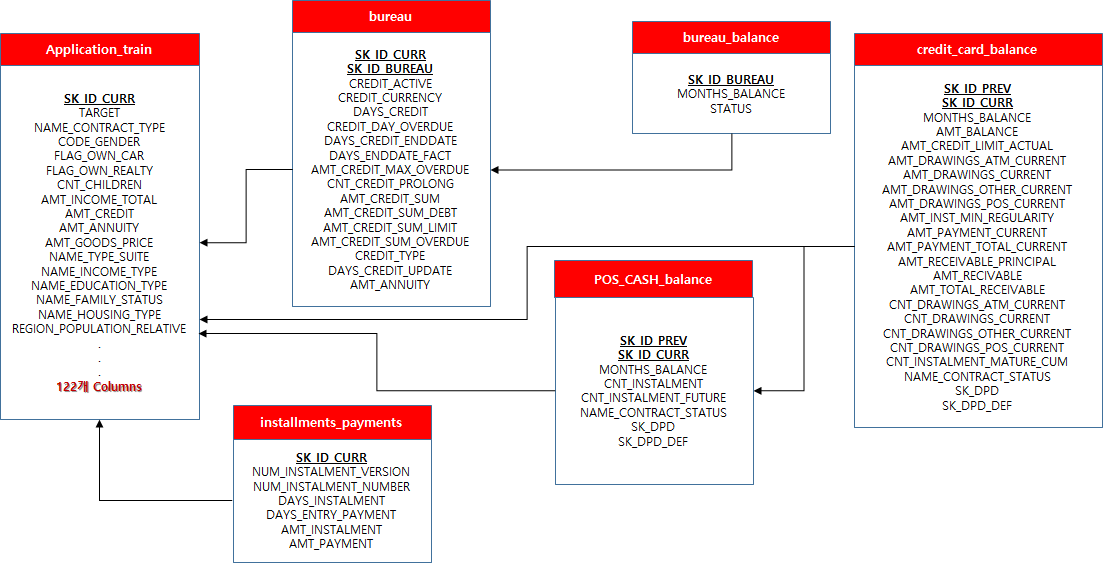

코드 공유된 전처리 적용 혹은 테이블 결합시 0.79수준의 AUROC결과가 나오지만, 공유 코드에는 그냥 TRAIN Data하나로만 나온 결과를 보여드리겠습니다.<br>
Code When applying shared preprocessing or combining tables, an AUROC result of 0.79 level is obtained, but in the shared code, only one TRAIN Data will be shown.

# Config

In [ ]:
import os

# 기본폴더(base folder)
dir_ad = '../input/../input/home-credit-default-risk'
# dir_ad = os.getcwd()

# 학습데이터, predict data 파일명(train, test file name)
train = 'application_train.csv'
test = 'application_test.csv'

# 어떤것을 분석 및 데이터 추출할지 구분할 수 있는 파일명 선택 
# tag = 'train_MAU_3M_pred_MAUX_4M'← 이런 방식으로 나올 것으로 예상
tag = 's_result'

# 모델 및 각종 산출물이 저장될 폴더
model_dir = os.path.join(dir_ad, tag + '_v')

# 레이블에 해당하는 컬럼(column corresponding to label: Y value)
target = 'TARGET'

# 타겟팅 대상을 식별하기 위한 컬럼(Column to identify the target)
index_col = 'SK_ID_CURR'

# 평가방법 "accuracy", "roc_auc","f1" 등 선택
choice = "roc_auc"

# Modeling

In [ ]:
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

In [ ]:
df_train = pd.read_csv(os.path.join(dir_ad, train))
df_test = pd.read_csv(os.path.join(dir_ad, test))

In [ ]:
num_cols = [col for col in df_test.columns if df_test[col].dtype in ["float16","float32","float64", "int64", "int32"]]
cat_cols = [col for col in df_test.columns if df_test[col].dtype not in ["float16","float32","float64", "int64", "int32"]]

In [ ]:
def detect_outliers(data, col_name):
    outlier_indices = []
    # iterate over features(columns)
    for col in col_name:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
def outlier_replace(data, col_name, q1=0.25, q3=0.75):
    quartile1 = data[col_name].quantile(q1)
    quartile3 = data[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    data.loc[(data[col_name] < low_limit), col_name] = low_limit
    data.loc[(data[col_name] > up_limit), col_name] = up_limit

In [ ]:
for i in num_cols:
    outlier_replace(df_train,i)
    outlier_replace(df_test, i)

In [ ]:
df_train = df_train.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df_test = df_test.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

In [ ]:
def count_plot(d, y, x):
    plt.figure(figsize=(12,6))
    sns.countplot(x = d[y], hue = x, data=d)
    plt.ylabel('Number of people')
    plt.title('Survival count by '+ x)

In [ ]:
over_column_name = list()

for i in num_cols:
    if (len(df_train[i].value_counts())<20):
        count_plot(df_train, target, i)
    elif (len(df_train[i].value_counts())>20):
        over_column_name.append(i)

# print('Column내 변수가 10개 이상의 Column은 하단과 같습니다.\n변수 10개 미만의 Column과 Survived 숫자 분포는 그래프와 같습니다.')
# print(over_column_name)

In [ ]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [ ]:
test_col = []
delete_train = []

for i in df_test.columns:
    test_col.append(i)
for j in df_train.columns:
    if j not in test_col:
        delete_train.append(j)
delete_train.remove(target)

In [ ]:
train_col = []
delete_test = []

for i in df_train.columns:
    train_col.append(i)
for j in df_test.columns:
    if j not in train_col:
        delete_test.append(j)

In [ ]:
for delete in delete_train:
    df_train = df_train.drop([delete],axis=1)
    
for delete in delete_test:
    df_test = df_test.drop([delete],axis=1)

In [ ]:
for i in num_cols:
    sns.factorplot(x=target, y = i,data = df_train, kind="violin")

In [ ]:
random_state_val =777
test_size_val =0.1

df_train, df_val = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

drop_col = [target, index_col]
y_nm = target

df_train_x = df_train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(df_train[y_nm])

df_val_x = df_val.drop(drop_col, axis = 1)
df_val_y = pd.DataFrame(df_val[y_nm])

In [ ]:
LGBClassifier = lgb.LGBMClassifier(objective='binary',
                                   nthread=4,
                                   n_estimators=10000,
                                   learning_rate=0.02,
                                   num_leaves=34,
                                   colsample_bytree=0.9497036,
                                   subsample=0.8715623,
                                   max_depth=8,
                                   reg_alpha=0.041545473,
                                   reg_lambda=0.0735294,
                                   min_split_gain=0.0222415,
                                   min_child_weight=39.3259775,
                                   silent=-1,
                                   random_state = 42)

In [ ]:
start = datetime.datetime.now()
lgbm = LGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], 
                       eval_metric ='auc',
                       early_stopping_rounds = 200,
                       verbose = True)
end = datetime.datetime.now()
end-start

In [ ]:
feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_train_x.columns), reverse = True), columns = ['Value', 'Feature'])
# feature_imp.to_excel("feature_imp.xlsx")

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:10].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()
# plt.savefig('lightGBM_ Importances.png')

In [ ]:
fpr, tpr, _ = roc_curve(df_val_y, lgbm.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold =0.
val_y_prob = lgbm.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold))
print('Complete')

In [ ]:
predict_lgbm = lgbm.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

In [ ]:
conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
XGBClassifier = xgb.XGBClassifier(max_depth = 6,
                                 learning_rate = 0.01,
                                 n_estimators = 10000,
                                 objective = 'binary:logistic',
                                 tree_method = 'gpu_hist',
                                 booster = 'gbtree',
                                 seed = 23,
                                 min_child_weight = 35,
                                 subsample = 0.7,
                                 alpha = 0.25,
                                 n_jobs = -1
                                 )

In [ ]:
start = datetime.datetime.now()
xgb = XGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], 
                       eval_metric = 'auc',
                       early_stopping_rounds = 200,
                       verbose = True)
end = datetime.datetime.now()
end-start

In [ ]:
fi_vals = xgb.get_booster().get_score(importance_type = 'weight')
fi_dict = {df_train_x.columns[i]:float(fi_vals.get('f'+str(i),0.)) for i in range(len(df_train_x.columns))}
feature_importance_ = sorted(fi_dict.items(), key=operator.itemgetter(1), reverse=True)
feature_importance_result = OrderedDict(feature_importance_)

importance = pd.DataFrame(feature_importance_)
importance.columns = ['feature','weight']
importance.head(10)

In [ ]:
importance_ten = importance[:10]
importance_ten.set_index('feature').sort_values(by='weight').plot(kind='barh', figsize=(5, 5))

In [ ]:
fpr, tpr, _ = roc_curve(df_val_y, xgb.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold_2 =0.
val_y_prob = xgb.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold_2 = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold_2 = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold_2 = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold_2 = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold_2 = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold_2))
print('Complete')

In [ ]:
predict_xgb = xgb.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_xgb > opt_threshold_2, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_xgb)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_test = df_test.drop(index_col, axis = 1)

test_xgb = pd.Series(xgb.predict(df_test.values), name="XGB")
test_lgbm = pd.Series(lgbm.predict(df_test.values), name="LGBM")

# Concatenate all classifier results
ensemble_results = pd.concat([test_xgb,test_lgbm],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
votingC = VotingClassifier(estimators=[('xgb', xgb),('lgbm', lgbm)], voting='soft')
votingC = votingC.fit(df_train_x.values, df_train_y.values)

In [ ]:
fpr, tpr, _ = roc_curve(df_val_y, votingC.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold_3 =0.
val_y_prob = votingC.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold_3 = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold_3 = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold_3 = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold_3 = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold_3 = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold_3))
print('Complete')

In [ ]:
predict_votingC = votingC.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_votingC > opt_threshold_3, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_votingC)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predict_votingC = votingC.predict_proba(df_test.values)[:,1]

df_test = pd.read_csv(os.path.join(dir_ad, test))
test_result= pd.DataFrame(predict_votingC)
test_result.columns = [target]
predict = test_result[target]
Id_No = df_test[index_col]
submission = pd.DataFrame({index_col: Id_No, target: predict})
# submission[target] = submission[target].astype('Int64')
submission.to_csv('submission.csv', index=False)
submission.head()